<a href="https://colab.research.google.com/github/Crystalheart0828/AI-projects-notebooks/blob/main/Lazy_Pro_Automate_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lazy Pro: Automate Research

Created with heart and soul by [Karen Ding](https://karending.com)

## License and Usage
This tutorial is licensed under Creative Commons Attribution 4.0 International (CC BY 4.0)

Feel free to use, modify, and share this tutorial!

If you find it helpful, please consider:
1. Linking back to [the original webpage](https://karending.com/marketing-automation-with-ai/automate-market-research/)
2. Mentioning where you learned from it
3. Contributing improvements back to help others learn too

You are free to:
- Use and adapt this tutorial for any purpose
- Share, copy, and redistribute in any medium
- Modify, remix, and build upon the material

For the full license details: https://creativecommons.org/licenses/by/4.0/



---



## Overview

**Lazy Pro: Automate Research** is a powerful tool that automates the process of collecting and organizing AI-related news articles. It performs two main functions:

1.   Collecting relevant news articles using the **[News API](https://newsapi.org/)** and export the news to Google Sheet
2.   Filter the news based on your need


## Prerequisites (Your Key Ingredients! 🧰)

#### **Google Sheet API** and **Google Cloud Credential**
Don’t know what this is? No worries—I’ve been there too! Simply ask any LLM (e.g., ChatGPT, Claude, Gemini, etc.) the following prompt:

> I’m new to Google Cloud Console and haven’t built a project yet. Could you please walk me through the step-by-step process to download the credentials file and activate the Google Sheets API?

#### **News API Key**
News API will serve as the news source for this tool. Click the "Get API Key" button in the top-right corner, retrieve your API key, and store it in a secure document.

What is an API key? Think of it as a house key for accessing a data warehouse.

As you become more advanced, you can replace the News API with another news source or even create a web crawler to collect news data directly.

#### **Google Colab**
Google Colab is a fantastic cloud-based IDE (Integrated Development Environment). Like Google Docs, your scripts are saved in your Google Drive and can be easily shared with others. Simply sign in to Google Colab with your Google account, and you’re ready to get started.

In this tutorial, I’ll use Google Colab to demonstrate the steps. However, there are many other IDEs available. If you choose to use a different IDE, you may need to tweak the scripts to ensure the variables are configured correctly.

#### **Google Sheet**
Google Sheets will serve as the location for the news query. To find the Google Sheet ID, check the hyperlink or ask an LLM, "How do I find my Google Sheet ID?"


## Step-by-Step Guide

### **Step 1: Setting Up Your Environment 🛠️**
What's happening here: Think of this as preparing your kitchen before cooking. We're getting all our tools ready by installing the necessary Python packages. Just like you can't cook without pots and pans, you can't run the script without these packages!

We are going to install the following Python packages:
* newsapi-python (for getting news articles)
* google-auth (for Google authentication)
* google-api-python-client (for using Google services)
* gspread (for working with Google Sheets)
* requests (for making internet requests)


In [ ]:
pip install newsapi-python google-auth google-api-python-client gspread requests

### **Step 2: Importing Required Tools 📚**
What's happening here: Now we're bringing in all the tools we'll need. It's like taking out all the utensils and ingredients from your kitchen cabinets before starting to cook.

In [ ]:
import gspread
from google.oauth2.service_account import Credentials
from newsapi import NewsApiClient
import json

import requests
from googleapiclient.discovery import build
from datetime import datetime

import time

from google.colab import userdata
import os

### **Step 3: Setting Up Google Authentication 🔑**
What's happening here: This is like showing your ID to enter a restricted area. We're telling Google who we are and what we want to do with their services (in this case, use Google Sheets and Drive).

#### If you are first time uploading the google credential file, check this:

*   Click the folder icon on the left hand side, and upload your Google Cloud Credential file (a .json file).
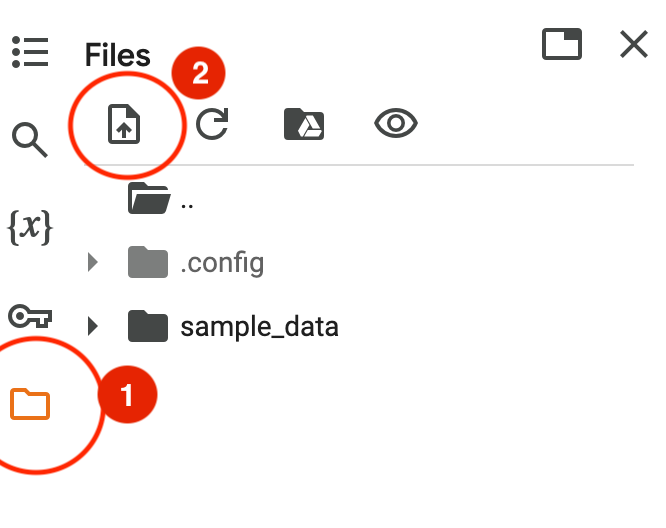
*   Click the three dot menu on your Google Cloud Credential file, click "Copy path"
*   Paste the value (which should be a directory path) to the following variable `credential_path`





In [ ]:
# Define the scope and authorize the credentials
SCOPES = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive"]
credentials_path = 'your_credentials_file.json'  # Replace with your actual credentials file path
creds = Credentials.from_service_account_file(credentials_path, scopes=SCOPES)

# Initialize gspread client
client = gspread.authorize(creds)

### **Step 4: Configuring Your Research Parameters in Colab** ⚙️
What's happening here: Instead of hardcoding our sensitive information directly in the code (which isn't secure!), we'll use Google Colab's built-in Secrets feature. Think of Secrets as a secure vault for storing your private information.

First, let's set up your secrets:

1. Click on the folder icon 📁 in the left sidebar of Colab
2. Click on the 🔒 icon (Secrets) at the bottom of the file browser
3. Add the following secrets by clicking "Add new secret":

Required secrets to add:

* news_api: Your NewsAPI key
* sheet_id: Your Google Sheet ID
* starting_date: Start date for news collection (format: YYYY-MM-DD)
* ending_date: End date for news collection (format: YYYY-MM-DD)

Here's how to access these secrets in your code:

In [ ]:
from google.colab import userdata

# Safely get your configuration from Colab Secrets
news_api_key = userdata.get('news_api')
sheet_id = userdata.get('sheet_id')
starting_date = userdata.get('starting_date')
ending_date = userdata.get('ending_date')

# Your keywords list
keywords = ["Keyword A", "Keyword B", "Keyword C", "Keyword D", "Keyword E"]  # Modify these based on your research needs
language = "en" # Replace with your desired search language, eg. en (English), es (Spanish), fr(French), zh(Chinese), de(German)...etc.


### **Step 5: Running the Research Process 🔄**
What's happening here: This is where the magic happens! The script will automatically:

* Search for news articles about your chosen topics
* Collect all the relevant information
* Organize it neatly in a Google Sheet

#### a. Connect NewsAPI

In [ ]:
# Init
newsapi = NewsApiClient(api_key = userdata.get('news_api_key'))

#### b. Build Functions

##### Export The News to Google Sheet

In [ ]:
def export_to_google_sheet(all_articles, sheet_id, sheet_name):
    # Open the Google Sheet and add a new worksheet or access an existing one
    sheet = client.open_by_key(sheet_id)
    try:
        worksheet = sheet.worksheet(sheet_name)
        worksheet.clear()
    except gspread.exceptions.WorksheetNotFound:
        worksheet = sheet.add_worksheet(title=sheet_name, rows="100", cols="20")

    # Prepare the header
    header = ["Title", "Author", "Source", "Published At", "Description", "URL", "Content"]
    worksheet.append_row(header)

    # Prepare the data rows for batch update
    rows = []
    for article in all_articles['articles']:
        title = article.get('title', 'No Title')
        author = article.get('author', 'No Author')
        source = article['source']['name']
        published_at = article.get('publishedAt')
        description = article.get('description', 'No Description')
        url = article.get('url', 'No URL')
        content = article.get('content', 'No Content')

        rows.append([title, author, source, published_at, description, url, content])

    # Perform batch update
    if rows:
        worksheet.append_rows(rows)

    print(f"Articles exported successfully to the sheet: https://docs.google.com/spreadsheets/d/{sheet_id}/edit#gid={worksheet.id}")


#### c. Query News API

*   You can update the parameters to have advanced queries based on your need. Check [the official documentation](https://newsapi.org/docs/client-libraries/python) to know how it works.




In [ ]:
# Function to query NewsAPI for a given keyword
def query_news_api(keyword, starting_date, ending_date, pages):
    all_articles = newsapi.get_everything(q=keyword,
                                          sources=None,
                                          domains=None,
                                          from_param= starting_date,
                                          to= ending_date,
                                          language='en',
                                          sort_by='relevancy',
                                          page= pages)
    return all_articles

#### d. Process multiple keywords

In [ ]:
def process_keywords(keywords, starting_date, ending_date, pages, sheet_id):
    for keyword in keywords:
        print(f"Processing keyword: {keyword}")
        # Query the News API for the current keyword
        all_articles = query_news_api(keyword, starting_date, ending_date, pages)

        # Use the keyword directly as the sheet name
        sheet_name = keyword  # Assuming the tab in the Google Sheet has the exact same name as the keyword

        # Export the articles to the specific sheet/tab named after the keyword
        export_to_google_sheet(all_articles, sheet_id, sheet_name)
        print(f"Finished processing for keyword: {keyword}")

#### e.Run Main Function

In [ ]:
if __name__ == "__main__":
    keywords = ["Keyword A","Keyword B", "Keyword C", "Keyword D", "Keyword E"]
    starting_date = starting_date
    ending_date = ending_date
    pages = 5
    sheet_id = sheet_id

    process_keywords(keywords, starting_date, ending_date, pages, sheet_id)

### **Final Step: Pro Tips for Colab Users!** 💡
1. Your Colab secrets are secure and won't be visible in your notebook's output or shared versions
2. Remember to set up your secrets before running the notebook
3. If you're sharing your notebook, the secrets won't be shared - each user needs to set up their own
4. Colab sessions expire after a while, so you might need to rerun the authentication steps
5. To avoid timeouts during long research sessions, you can go to Runtime → Change runtime type and select a GPU or TPU runtime for better performance

© 2025 Karen Ding. Created with heart and soul. Find more tutorials at [karending.com](https://karending.com)